In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2
import tensorflow as tf
import shutil

# 1 数据预处理

## 数据读取

In [3]:
data_path = r'C:\Users\chen\Desktop\人工智能实习报告\3Dircadb1\3Dircadb1.1\PATIENT_DICOM'
#批量读取
image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
os.listdir(data_path)
image_slices.sort(key=lambda x:x.InstanceNumber)
#提取像素值
image_array = np.array([i.pixel_array for i in image_slices])

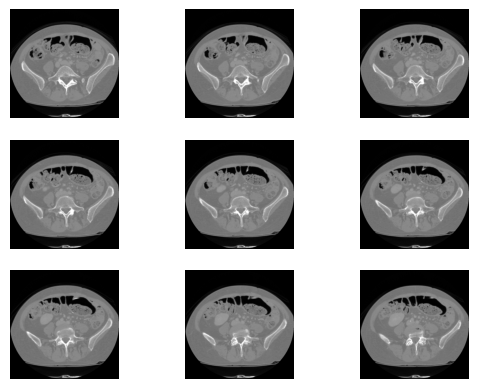

In [4]:
#可视化读取数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(image_array[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()

## CT图数据增强：windowing方法（ct对比增强）

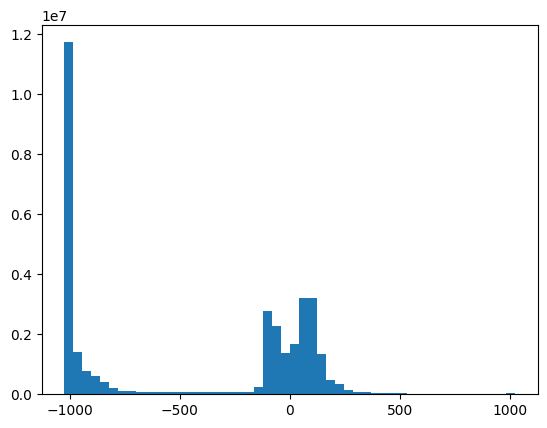

In [5]:
#像素值
plt.hist(image_array.reshape(-1,1),bins = 50)
plt.show()

In [6]:
#windowing自定义函数
def windowing(img,window_width,window_center):#需要增强的图片、窗宽、中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8')

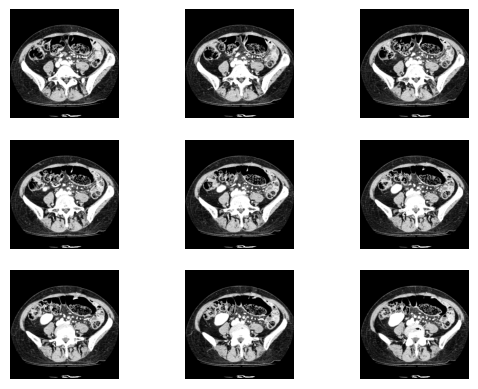

In [7]:
img_ct = windowing(image_array,250,0)
#可视化读取数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()

## 直方图均衡化

In [8]:
img_ct.shape
clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize=(8,8))
clahe.apply(img_ct[0])

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

In [9]:
# 自定义批量均衡化函数
def clahe_en(imgs):
    assert len(imgs.shape) == 3, "输入的图像应该是一个三维数组 (n, h, w)，其中 n 是图像数量。"  
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        # 将图像转换为 uint8 类型，并应用 CLAHE
        img_res[i, :, :] = clahe.apply(imgs[i, :, :].astype(np.uint8))
    # 返回归一化到 [0, 1] 之间的结果
    return img_res / 255.0


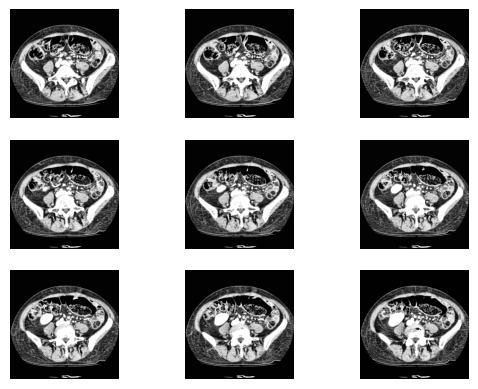

In [10]:
img_clahe = clahe_en(img_ct)
img_ct = windowing(image_array,250,0)
#可视化读取数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_clahe[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()

## 获取肿瘤部位CT图和掩膜图

In [11]:
data_path_mask = r'C:\Users\chen\Desktop\人工智能实习报告\3Dircadb1\3Dircadb1.1\MASKS_DICOM\livertumor01'
#批量读取
tumor_slices = [pydicom.dcmread(os.path.join(data_path_mask,file_name)) for file_name in os.listdir(data_path_mask)]
tumor_slices.sort(key=lambda x:x.InstanceNumber)
#提取像素值
tumor_array = np.array([i.pixel_array for i in tumor_slices])

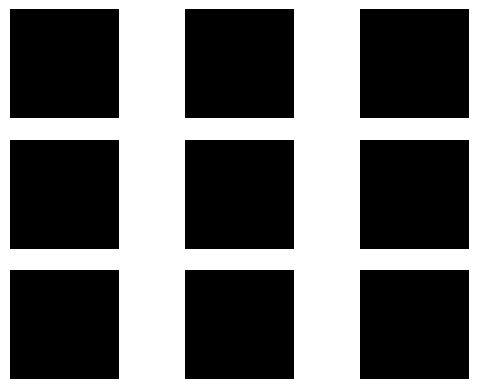

In [12]:
#可视化读取数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(tumor_array[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()



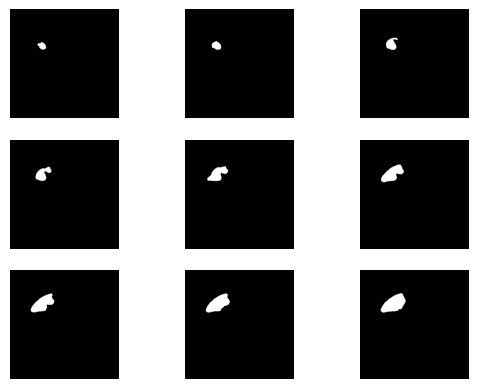

In [13]:
#可视化读取数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(tumor_array[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()



In [14]:
#一开始还没有肿瘤的掩模图全部是黑色，对应的像素数组全为0
index = [i.sum()>0 for i in tumor_array]
#提取掩膜图的肿瘤部分
img_tumor = tumor_array[index]
#对增强后的CT图提取肿瘤部分
img_patient = img_clahe[index]

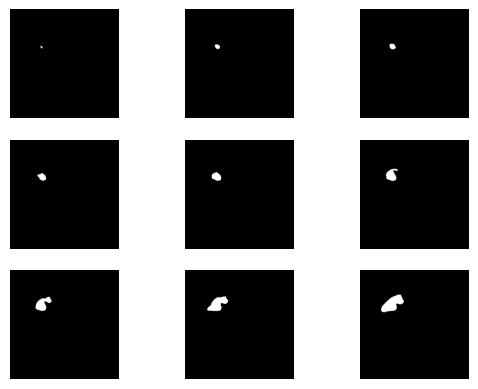

In [15]:
#可视化肿瘤数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_tumor[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()

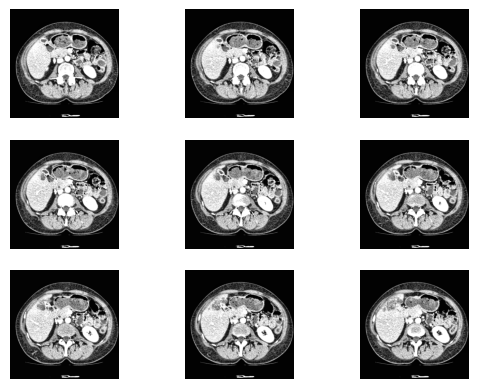

In [16]:
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_patient[i],cmap = 'gray')
    plt.axis('off')
    j += 1
plt.show()

## 保留肿瘤数据

In [17]:
patient_save_path = r'C:\Users\chen\Desktop\人工智能实习报告\tmp\patient'
tumor_save_path = r'C:\Users\chen\Desktop\人工智能实习报告\tmp\tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [18]:
# for i in range(len(img_patient)):
#     plt.imsave(os.path.join(patient_save_path,f'{i}.jpg'),img_patient[i],cmap='gray')#CT图
#     plt.imsave(os.path.join(tumor_save_path,f'{i}.jpg'),img_patient[i],cmap='gray')#掩膜图
    

In [19]:
#保存所有的肿瘤数据
livertumor_path = r'C:\Users\chen\Desktop\人工智能实习报告\3Dircadb1\3Dircadb1.1\MASKS_DICOM'
tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]

#提取所有肿瘤数据
j = 0
for tumor_path in tumor_paths:
    print('正在处理第%d个肿瘤'%j)
    #批量读取
    tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
    tumor_slices.sort(key=lambda x:x.InstanceNumber)
    #提取像素值
    tumor_array = np.array([i.pixel_array for i in tumor_slices])
    #提取掩膜图的肿瘤部分
    img_tumor = tumor_array[index]
    #对增强后的CT图提取肿瘤部分
    img_patient = img_clahe[index]
    for i in range(len(img_patient)):
        plt.imsave(os.path.join(patient_save_path,f'{j}_{i}.jpg'),img_patient[i],cmap='gray')#CT图
        plt.imsave(os.path.join(tumor_save_path,f'{j}_{i}.jpg'),img_patient[i],cmap='gray')#掩膜图
    j+=1
    

正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第4个肿瘤
正在处理第5个肿瘤
正在处理第6个肿瘤


## 对所有病人的数据进行处理

In [20]:
for num in range(1, 21):
    print('正在处理第%d位病人的数据' % num)
    # ---CT图处理---
    data_path = fr'C:\Users\chen\Desktop\人工智能实习报告\3Dircadb1\3Dircadb1.{num}\PATIENT_DICOM'
    # 批量读取
    image_slices = [pydicom.dcmread(os.path.join(data_path, file_name)) for file_name in os.listdir(data_path)]
    image_slices.sort(key=lambda x: x.InstanceNumber)
    # 提取像素值
    image_array = np.array([i.pixel_array for i in image_slices])
    
    # CT图增强
    img_ct = windowing(image_array, 250, 0)
    
    # 直方图均衡法
    img_clahe = clahe_en(img_ct)
    
    # ---掩模图处理---
    livertumor_path = fr'C:\Users\chen\Desktop\人工智能实习报告\3Dircadb1\3Dircadb1.{num}\MASKS_DICOM'
    tumor_paths = [os.path.join(livertumor_path, i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
    tumor_paths.sort()
    
    j = 0
    for tumor_path in tumor_paths:
        print('正在处理第%d个肿瘤' % j)
        # 批量读取
        tumor_slices = [pydicom.dcmread(os.path.join(tumor_path, file_name)) for file_name in os.listdir(tumor_path)]
        tumor_slices.sort(key=lambda x: x.InstanceNumber)
        # 提取像素值
        tumor_array = np.array([i.pixel_array for i in tumor_slices])
        
        # 确保 index 的维度与 tumor_array 和 img_clahe 匹配
        index = np.ones(tumor_array.shape[0], dtype=bool)  # 示例: 创建一个全为 True 的布尔数组
        
        if len(index) == len(tumor_array) == len(img_clahe):
            img_tumor = tumor_array[index]
            img_patient = img_clahe[index]
            
            for i in range(len(img_patient)):
                plt.imsave(os.path.join(patient_save_path, f'{num}_{j}_{i}.jpg'), img_patient[i], cmap='gray')  # CT图
                plt.imsave(os.path.join(tumor_save_path, f'{num}_{j}_{i}.jpg'), img_tumor[i], cmap='gray')  # 掩膜图
        else:
            print(f"Index length: {len(index)}, Tumor array length: {len(tumor_array)}, CT array length: {len(img_clahe)}")
            raise ValueError("Index length does not match tumor_array or img_clahe length.")
        
        j += 1


正在处理第1位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第4个肿瘤
正在处理第5个肿瘤
正在处理第6个肿瘤
正在处理第2位病人的数据
正在处理第0个肿瘤
正在处理第3位病人的数据
正在处理第0个肿瘤
正在处理第4位病人的数据
正在处理第0个肿瘤
正在处理第5位病人的数据
正在处理第6位病人的数据
正在处理第0个肿瘤
正在处理第7位病人的数据
正在处理第8位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第9位病人的数据
正在处理第0个肿瘤
正在处理第10位病人的数据
正在处理第0个肿瘤
正在处理第11位病人的数据
正在处理第12位病人的数据
正在处理第0个肿瘤
正在处理第13位病人的数据
正在处理第0个肿瘤
正在处理第14位病人的数据
正在处理第15位病人的数据
正在处理第0个肿瘤
正在处理第16位病人的数据
正在处理第0个肿瘤
正在处理第17位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第18位病人的数据
正在处理第0个肿瘤
正在处理第19位病人的数据
正在处理第0个肿瘤
正在处理第20位病人的数据


# 图像数据增强：定义ImageDataGenerator图片生成器、使用flow_from_directory方法图像增强

In [21]:
import os
import shutil
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 定义图片生成器

In [22]:
generator_args = dict(
    rotation_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    zoom_range = 0.05,
    horizontal_flip = False,
    vertical_flip = False,
    
)
ct_datagen = ImageDataGenerator(generator_args)
mask_datagen = ImageDataGenerator(generator_args)

## 图像增强实现

In [23]:
#保存图像增强后的数据
save_datagen_path = r'C:\Users\chen\Desktop\人工智能实习报告\tmp2'
if os.path.exists(save_datagen_path):
    shutil.rmtree(save_datagen_path)
os.makedirs(save_datagen_path)

In [24]:
#目标路径-ct图的增强
generator_path = r'C:\Users\chen\Desktop\人工智能实习报告\tmp'
ct_generator = ct_datagen.flow_from_directory(
    generator_path,
    classes=['patient'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (512,512),
    batch_size=2,
    save_to_dir=save_datagen_path,
    save_prefix='ct_',
    seed = 123,
)
mask_generator = mask_datagen.flow_from_directory(
    generator_path,
    classes=['tumor'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (512,512),
    batch_size=2,
    save_to_dir=save_datagen_path,
    save_prefix='mask_',
    seed = 123,
)
train_generator = zip(ct_generator,mask_generator)

Found 3463 images belonging to 1 classes.
Found 3463 images belonging to 1 classes.


(512, 512) (2, 512, 512, 1)


C:\Users\chen\anaconda3\lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


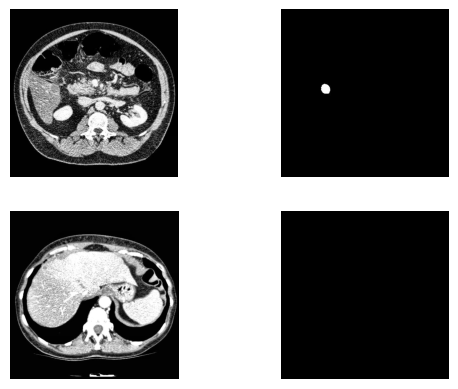

In [25]:
#可视化
for ct,mask in train_generator:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    break
plt.show()

## 图像归一化

In [26]:
def adjust_data(ct,mask):
    ct /= 255.0
    mask /= 255.0
    mask[mask>0.5] = 1
    mask[mask<0.5] = 0
    return ct,mask

## 整合图像增强的步骤

In [27]:
#自定义图像增强函数
def train_generator():
    #1. 定义图像生成器
    generator_args = dict(
        rotation_range = 0.1,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = False,
        vertical_flip = False,

    )
    #2.分别对ct图和掩模图做图像增强
    ct_datagen = ImageDataGenerator(generator_args)
    mask_datagen = ImageDataGenerator(generator_args)
    #3.实践图像增强
    generator_path = r'C:\Users\chen\Desktop\人工智能实习报告\tmp'
    ct_generator = ct_datagen.flow_from_directory(
        generator_path,
        classes=['patient'],
        class_mode=None,
        color_mode = 'grayscale',
        target_size = (512,512),
        batch_size=2,
        save_to_dir=save_datagen_path,
        save_prefix='ct_',
        seed = 123,
    )
    mask_generator = mask_datagen.flow_from_directory(
        generator_path,
        classes=['tumor'],
        class_mode=None,
        color_mode = 'grayscale',
        target_size = (512,512),
        batch_size=2,
        save_to_dir=save_datagen_path,
        save_prefix='mask_',
        seed = 123,
    )
    train_generator = zip(ct_generator,mask_generator)#成组处理
    #4.增强后的图片做归一化处理
    for (ct,mask) in train_generator:
        yield adjust_data(ct,mask)

# 构建模型

## 搭建模型

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate

K.clear_session()
def u_net(input_size=(512, 512, 1)):
    # 输入层
    inputs = Input(input_size)
    
    # 卷积层
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    
    # 池化层
    pool1 = MaxPool2D(pool_size=(2, 2))(conv2)
    
    # 卷积层
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    # 池化层
    pool2 = MaxPool2D(pool_size=(2, 2))(conv4)
    
    # 卷积层
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    # 池化层
    pool3 = MaxPool2D(pool_size=(2, 2))(conv6)
    
    # 卷积层
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    # 池化层
    pool4 = MaxPool2D(pool_size=(2, 2))(conv8)
    
    # 卷积层
    conv9 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv10 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # 反卷积
    up1 = UpSampling2D((2, 2))(conv10)
    
    # 卷积层
    conv11 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concatenate([up1, conv8], axis=3))
    conv12 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)
    
    # 反卷积
    up2 = UpSampling2D((2, 2))(conv12)
    
    # 卷积层
    conv13 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concatenate([up2, conv6], axis=3))
    conv14 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv13)
    
    # 反卷积
    up3 = UpSampling2D((2, 2))(conv14)
    
    # 卷积层
    conv15 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concatenate([up3, conv4], axis=3))
    conv16 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv15)
    
    # 反卷积
    up4 = UpSampling2D((2, 2))(conv16)
    
    # 卷积层
    conv17 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concatenate([up4, conv2], axis=3))
    conv18 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv17)
    
    # 输出层
    outputs = Conv2D(1, 1, activation='sigmoid')(conv18)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])#模型编译
    
    return model

# 创建U-Net模型
model = u_net()
model.summary()  # 打印模型结构


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 512, 512, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 512, 512, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 256, 256, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 128, 128, 128)     │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 256)     │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 256)     │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 64, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 32, 32, 512)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 32, 32, 1024)      │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 32, 32, 1024)      │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 64, 64, 1024)      │               

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

## 模型编译：损失函数（0-1二分类交叉熵）、优化器设计（Adam）、回调函数（callback）

## 模型训练

Found 3463 images belonging to 1 classes.
Found 3463 images belonging to 1 classes.
Epoch 1/50


C:\Users\chen\anaconda3\lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9647 - loss: 0.4709 
Epoch 1: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


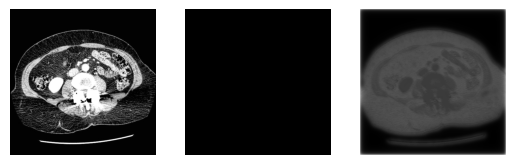

50/50 ━━━━━━━━━━━━━━━━━━━━ 551s 11s/step - accuracy: 0.9648 - loss: 0.4687
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9544 - loss: 0.2057 
Epoch 2: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


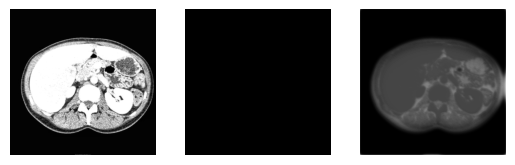

50/50 ━━━━━━━━━━━━━━━━━━━━ 540s 11s/step - accuracy: 0.9546 - loss: 0.2050
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9651 - loss: 0.1437 
Epoch 3: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


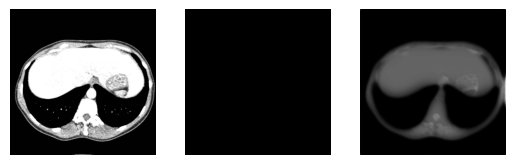

50/50 ━━━━━━━━━━━━━━━━━━━━ 554s 11s/step - accuracy: 0.9652 - loss: 0.1437
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9881 - loss: 0.3978 
Epoch 4: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


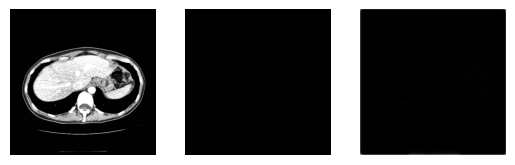

50/50 ━━━━━━━━━━━━━━━━━━━━ 551s 11s/step - accuracy: 0.9879 - loss: 0.3986
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9729 - loss: 0.3098 
Epoch 5: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


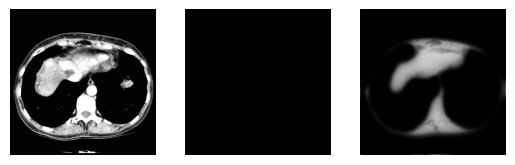

50/50 ━━━━━━━━━━━━━━━━━━━━ 536s 11s/step - accuracy: 0.9725 - loss: 0.3090
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9600 - loss: 0.1881 
Epoch 6: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


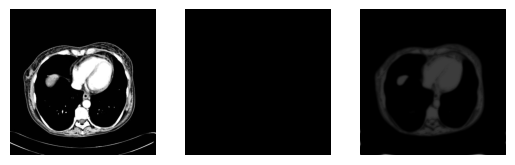

50/50 ━━━━━━━━━━━━━━━━━━━━ 545s 11s/step - accuracy: 0.9602 - loss: 0.1875
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9915 - loss: 0.0719 
Epoch 7: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


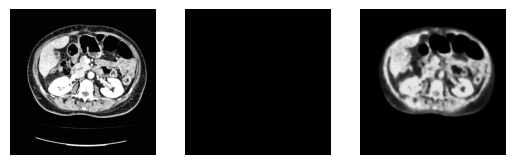

50/50 ━━━━━━━━━━━━━━━━━━━━ 545s 11s/step - accuracy: 0.9913 - loss: 0.0729
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9671 - loss: 0.1207 
Epoch 8: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


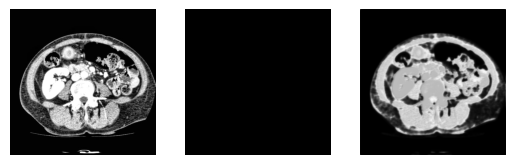

50/50 ━━━━━━━━━━━━━━━━━━━━ 544s 11s/step - accuracy: 0.9669 - loss: 0.1210
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9651 - loss: 0.1258 
Epoch 9: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


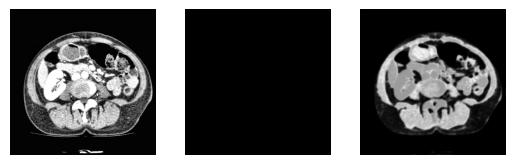

50/50 ━━━━━━━━━━━━━━━━━━━━ 549s 11s/step - accuracy: 0.9654 - loss: 0.1251
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9970 - loss: 0.0297 
Epoch 10: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


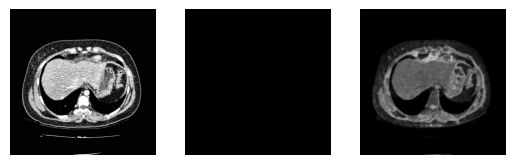

50/50 ━━━━━━━━━━━━━━━━━━━━ 529s 11s/step - accuracy: 0.9969 - loss: 0.0299
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9625 - loss: 0.1371 
Epoch 11: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


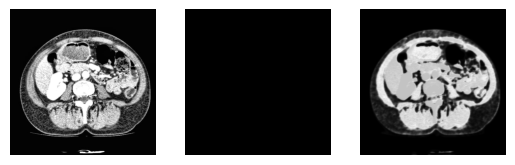

50/50 ━━━━━━━━━━━━━━━━━━━━ 552s 11s/step - accuracy: 0.9625 - loss: 0.1371
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9889 - loss: 0.0963 
Epoch 12: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


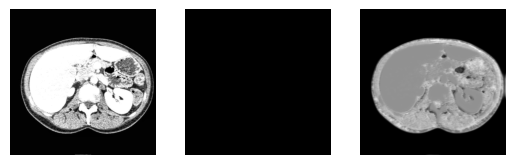

50/50 ━━━━━━━━━━━━━━━━━━━━ 586s 12s/step - accuracy: 0.9887 - loss: 0.0968
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9505 - loss: 0.1539 
Epoch 13: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


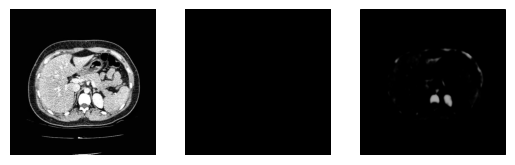

50/50 ━━━━━━━━━━━━━━━━━━━━ 543s 11s/step - accuracy: 0.9509 - loss: 0.1531
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9602 - loss: 0.2458 
Epoch 14: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


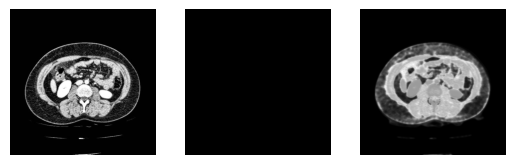

50/50 ━━━━━━━━━━━━━━━━━━━━ 556s 11s/step - accuracy: 0.9604 - loss: 0.2452
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9721 - loss: 0.1171 
Epoch 15: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


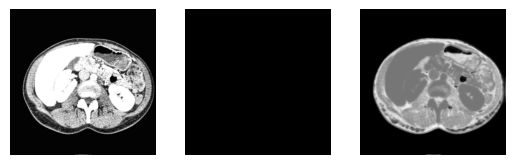

50/50 ━━━━━━━━━━━━━━━━━━━━ 545s 11s/step - accuracy: 0.9720 - loss: 0.1172
Epoch 16/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9769 - loss: 0.1048 
Epoch 16: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


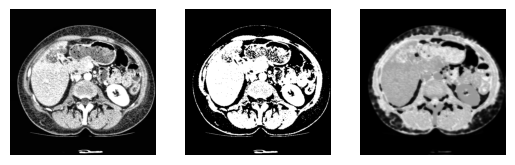

50/50 ━━━━━━━━━━━━━━━━━━━━ 585s 12s/step - accuracy: 0.9768 - loss: 0.1049
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9455 - loss: 0.1529 
Epoch 17: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


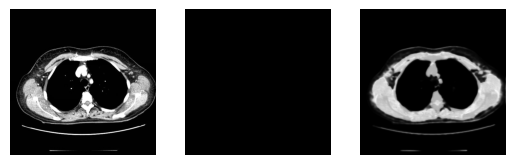

50/50 ━━━━━━━━━━━━━━━━━━━━ 542s 11s/step - accuracy: 0.9456 - loss: 0.1528
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9738 - loss: 0.0974 
Epoch 18: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


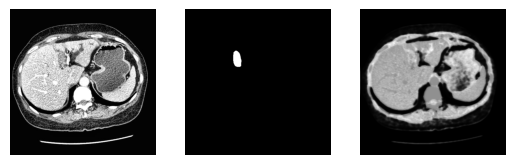

50/50 ━━━━━━━━━━━━━━━━━━━━ 540s 11s/step - accuracy: 0.9739 - loss: 0.0971
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9500 - loss: 0.1478 
Epoch 19: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


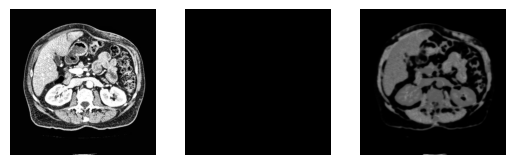

50/50 ━━━━━━━━━━━━━━━━━━━━ 552s 11s/step - accuracy: 0.9504 - loss: 0.1470
Epoch 20/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9844 - loss: 0.0671 
Epoch 20: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


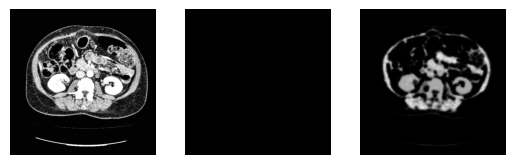

50/50 ━━━━━━━━━━━━━━━━━━━━ 551s 11s/step - accuracy: 0.9845 - loss: 0.0667
Epoch 21/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9886 - loss: 0.0553 
Epoch 21: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


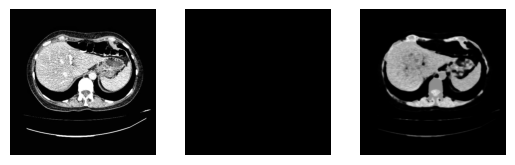

50/50 ━━━━━━━━━━━━━━━━━━━━ 553s 11s/step - accuracy: 0.9884 - loss: 0.0560
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9545 - loss: 0.1367 
Epoch 22: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


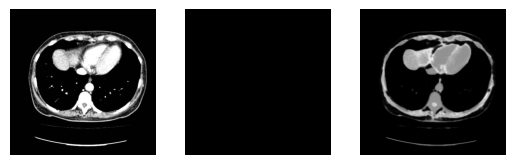

50/50 ━━━━━━━━━━━━━━━━━━━━ 551s 11s/step - accuracy: 0.9549 - loss: 0.1358
Epoch 23/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9750 - loss: 0.0905 
Epoch 23: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


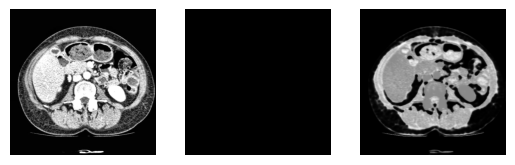

50/50 ━━━━━━━━━━━━━━━━━━━━ 555s 11s/step - accuracy: 0.9749 - loss: 0.0907
Epoch 24/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9746 - loss: 0.0891 
Epoch 24: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


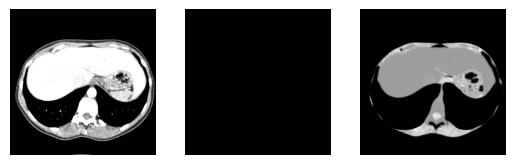

50/50 ━━━━━━━━━━━━━━━━━━━━ 557s 11s/step - accuracy: 0.9747 - loss: 0.0889
Epoch 25/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9906 - loss: 0.0720 
Epoch 25: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


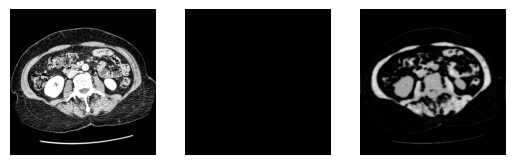

50/50 ━━━━━━━━━━━━━━━━━━━━ 559s 11s/step - accuracy: 0.9905 - loss: 0.0722
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9762 - loss: 0.0849 
Epoch 26: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


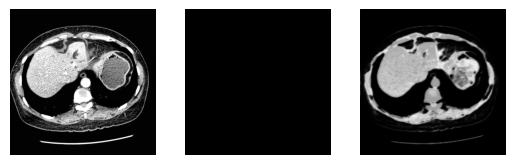

50/50 ━━━━━━━━━━━━━━━━━━━━ 561s 11s/step - accuracy: 0.9761 - loss: 0.0851
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9601 - loss: 0.1222 
Epoch 27: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


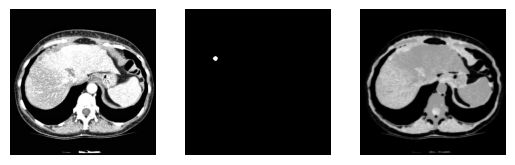

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9603 - loss: 0.1217
Epoch 28/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9742 - loss: 0.0894 
Epoch 28: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


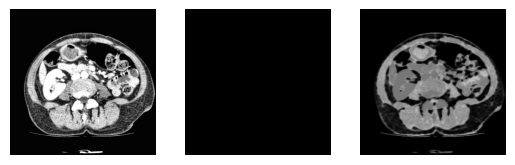

50/50 ━━━━━━━━━━━━━━━━━━━━ 574s 11s/step - accuracy: 0.9741 - loss: 0.0896
Epoch 29/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9772 - loss: 0.0841 
Epoch 29: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


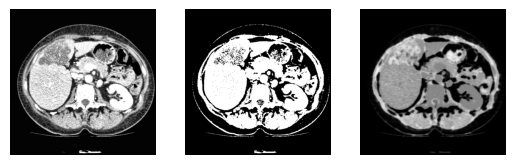

50/50 ━━━━━━━━━━━━━━━━━━━━ 567s 11s/step - accuracy: 0.9772 - loss: 0.0840
Epoch 30/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9595 - loss: 0.1260 
Epoch 30: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


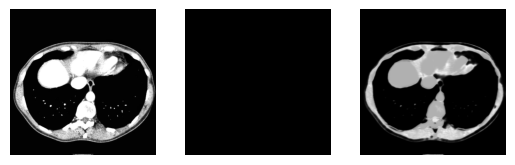

50/50 ━━━━━━━━━━━━━━━━━━━━ 566s 11s/step - accuracy: 0.9595 - loss: 0.1259
Epoch 31/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9735 - loss: 0.0943 
Epoch 31: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


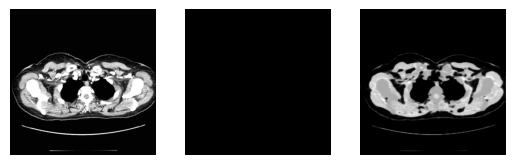

50/50 ━━━━━━━━━━━━━━━━━━━━ 567s 11s/step - accuracy: 0.9733 - loss: 0.0946
Epoch 32/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9399 - loss: 0.1603 
Epoch 32: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


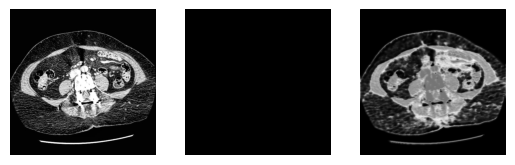

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9403 - loss: 0.1600
Epoch 33/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9754 - loss: 0.1493 
Epoch 33: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


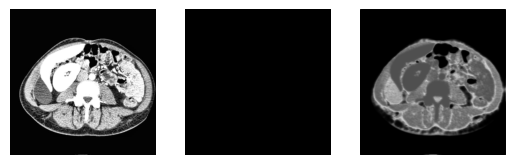

50/50 ━━━━━━━━━━━━━━━━━━━━ 575s 12s/step - accuracy: 0.9754 - loss: 0.1504
Epoch 34/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9725 - loss: 0.3024 
Epoch 34: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


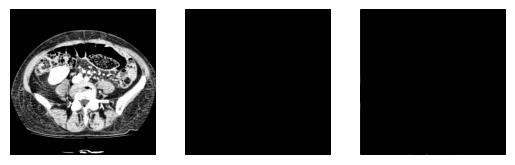

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9724 - loss: 0.3044
Epoch 35/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9923 - loss: 0.0853 
Epoch 35: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


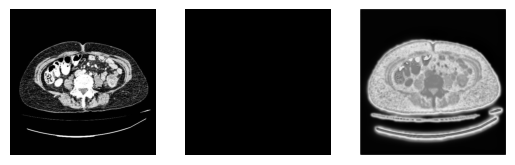

50/50 ━━━━━━━━━━━━━━━━━━━━ 581s 12s/step - accuracy: 0.9920 - loss: 0.0903
Epoch 36/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9629 - loss: 0.7680 
Epoch 36: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


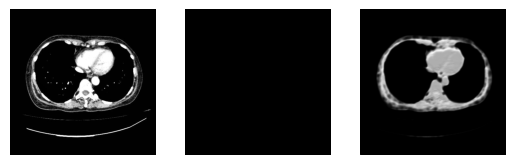

50/50 ━━━━━━━━━━━━━━━━━━━━ 582s 12s/step - accuracy: 0.9630 - loss: 0.7645
Epoch 37/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9689 - loss: 0.1197 
Epoch 37: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


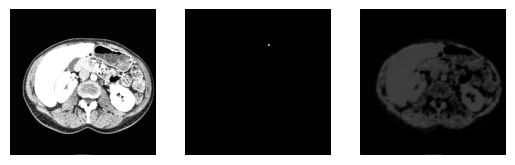

50/50 ━━━━━━━━━━━━━━━━━━━━ 573s 11s/step - accuracy: 0.9690 - loss: 0.1193
Epoch 38/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9816 - loss: 0.0790 
Epoch 38: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


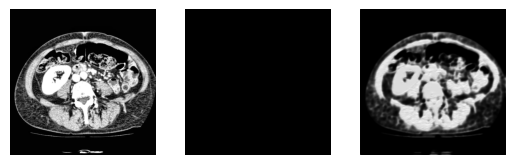

50/50 ━━━━━━━━━━━━━━━━━━━━ 575s 12s/step - accuracy: 0.9814 - loss: 0.0795
Epoch 39/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9825 - loss: 0.0921 
Epoch 39: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


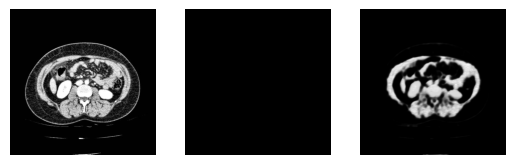

50/50 ━━━━━━━━━━━━━━━━━━━━ 588s 12s/step - accuracy: 0.9823 - loss: 0.0924
Epoch 40/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9856 - loss: 0.0674 
Epoch 40: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


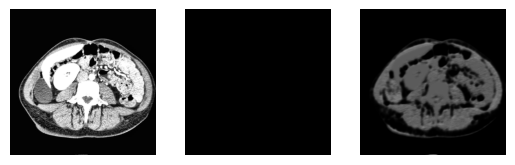

50/50 ━━━━━━━━━━━━━━━━━━━━ 584s 12s/step - accuracy: 0.9857 - loss: 0.0673
Epoch 41/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9839 - loss: 0.0714 
Epoch 41: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


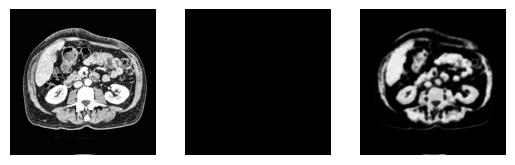

50/50 ━━━━━━━━━━━━━━━━━━━━ 579s 12s/step - accuracy: 0.9837 - loss: 0.0721
Epoch 42/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9861 - loss: 0.0887 
Epoch 42: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


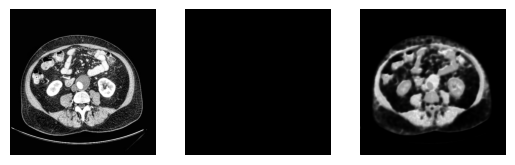

50/50 ━━━━━━━━━━━━━━━━━━━━ 574s 11s/step - accuracy: 0.9859 - loss: 0.0893
Epoch 43/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9729 - loss: 0.1008 
Epoch 43: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


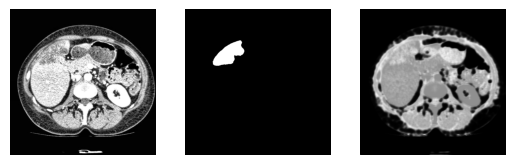

50/50 ━━━━━━━━━━━━━━━━━━━━ 573s 11s/step - accuracy: 0.9728 - loss: 0.1011
Epoch 44/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9705 - loss: 0.1047 
Epoch 44: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


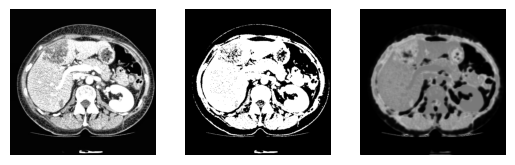

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9705 - loss: 0.1046
Epoch 45/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9790 - loss: 0.0808 
Epoch 45: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


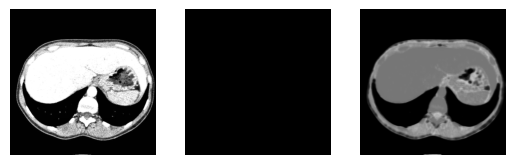

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9789 - loss: 0.0811
Epoch 46/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9475 - loss: 0.1501 
Epoch 46: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


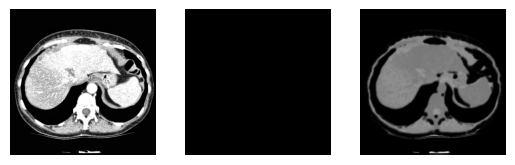

50/50 ━━━━━━━━━━━━━━━━━━━━ 575s 12s/step - accuracy: 0.9476 - loss: 0.1498
Epoch 47/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9905 - loss: 0.0614 
Epoch 47: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


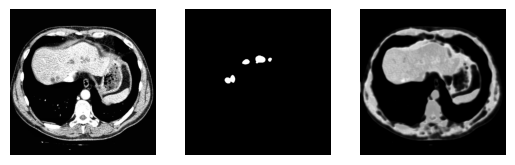

50/50 ━━━━━━━━━━━━━━━━━━━━ 582s 12s/step - accuracy: 0.9903 - loss: 0.0621
Epoch 48/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9632 - loss: 0.1244 
Epoch 48: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


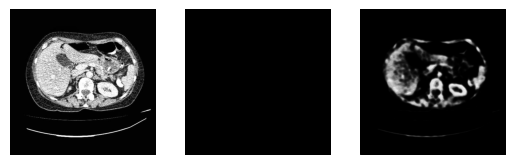

50/50 ━━━━━━━━━━━━━━━━━━━━ 577s 12s/step - accuracy: 0.9633 - loss: 0.1243
Epoch 49/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9737 - loss: 0.1034 
Epoch 49: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


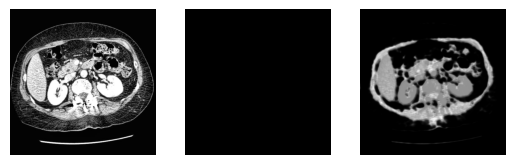

50/50 ━━━━━━━━━━━━━━━━━━━━ 577s 12s/step - accuracy: 0.9736 - loss: 0.1035
Epoch 50/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9450 - loss: 0.1568 
Epoch 50: saving model to C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


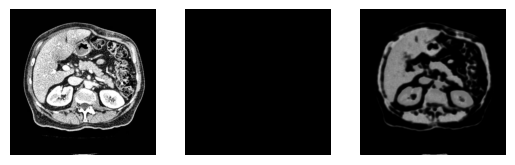

50/50 ━━━━━━━━━━━━━━━━━━━━ 572s 11s/step - accuracy: 0.9453 - loss: 0.1560


In [36]:
# 定义路径和回调函数
model_ckpt = ModelCheckpoint(r'C:\Users\chen\Desktop\人工智能实习报告\tmp\u_net-512-512-liver_tumor.keras', save_best_only=False, verbose=1)

# 自定义回调函数显示预测掩码
class ShowMask(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        print()
        for ct, mask in gene:
            plt.subplot(1, 3, 1)
            plt.imshow(ct[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            # 使用模型预测并显示结果
            predicted_mask = model.predict(ct[0].reshape(1, 512, 512, 1))[0]
            plt.imshow(predicted_mask, cmap='gray')
            plt.axis('off')
            plt.show()
            break  

# 训练模型并调用回调函数
model.fit(gene, steps_per_epoch=50, epochs=50, callbacks=[model_ckpt, ShowMask()])